In [1]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, AdditiveAttention, TimeDistributed
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import tokenizer_from_json

In [2]:
# Đọc chuỗi JSON từ tệp
with open("seq2seqData/tokenizer.json", "r", encoding="utf-8") as f:
    tokenizer_json_str = f.read()  # Đọc dạng chuỗi

# Tạo lại tokenizer từ chuỗi JSON
tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(tokenizer_json_str)

In [3]:
# Tham số
embedding_dim = 256
lstm_units = 512
vocab_size = len(tokenizer.word_index) + 1
max_length = 11  # Cập nhật để khớp với dataset mới
decoder_seq_length = max_length - 1 

# Inputs
fruit_classifier_output = Input(shape=(10,), name="fruit_classifier_output")
fruit_regression_output = Input(shape=(1,), name="fruit_regression_output")
encoder_inputs = Input(shape=(max_length,), name="encoder_inputs")
decoder_inputs = Input(shape=(decoder_seq_length,), name="decoder_inputs")

# Xử lý image features
regression_dense = Dense(64, activation='relu')(fruit_regression_output)
image_features = Concatenate()([fruit_classifier_output, regression_dense])
image_dense = Dense(lstm_units, activation='relu')(image_features)

# Encoder
encoder_embedding = Embedding(vocab_size, embedding_dim)(encoder_inputs)  # Remove mask_zero=True
encoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)

# Merge với image features
merged_state_h = Dense(lstm_units, activation='tanh')(Concatenate()([state_h, image_dense]))
merged_state_c = Dense(lstm_units, activation='tanh')(Concatenate()([state_c, image_dense]))

# Decoder
decoder_embedding = Embedding(vocab_size, embedding_dim)(decoder_inputs)  # Remove mask_zero=True
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[merged_state_h, merged_state_c])

# Attention
attention_layer = AdditiveAttention()
attention_output = attention_layer([decoder_outputs, encoder_outputs])  # Shape: [batch_size, decoder_seq_length, lstm_units]

# Concatenate decoder outputs and attention output
decoder_combined = Concatenate(axis=-1)([decoder_outputs, attention_output])  # Shape: [batch_size, 10, 1024]

# Dense layer để dự đoán token
output_dense = TimeDistributed(Dense(vocab_size, activation='softmax'))(decoder_combined)

# Model
model = Model(
    inputs=[encoder_inputs, fruit_classifier_output, fruit_regression_output, decoder_inputs],
    outputs=output_dense
)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ fruit_regression_o… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_inputs      │ (None, 11)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fruit_classifier_o… │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │        128 │ fruit_regression… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 11, 256)   │     38,656 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 74)        │          0 │ fruit_classifier… │
│ (Concatenate)       │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 11, 512), │  1,574,912 │ embedding[0][0]   │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │     38,400 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1024)      │          0 │ lstm[0][1],       │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 1024)      │          0 │ lstm[0][2],       │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 10, 256)   │     38,656 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │    524,800 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │    524,800 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 10, 512), │  1,574,912 │ embedding_1[0][0… │
│                     │ (None, 512),      │            │ dense_2[0][0],    │
│                     │ (None, 512)]      │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ additive_attention  │ (None, 10, 512)   │        512 │ lstm_1[0][0],     │
│ (AdditiveAttention) │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 10, 1024)  │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ additive_attenti… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 4,470,551 (17.05 MB)

 Trainable params: 4,470,551 (17.05 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Load dữ liệu mới
question_padded = np.load("seq2seqData/question_padded.npy")
answer_padded = np.load("seq2seqData/answer_padded.npy")
image_features = np.load("seq2seqData/image_features.npy")

# Chia tập train/valid
train_qs, val_qs, train_as, val_as, train_imgs, val_imgs = train_test_split(
    question_padded, answer_padded, image_features, test_size=0.2, random_state=42
)

# Chuẩn bị dữ liệu decoder
decoder_input_data = train_as[:, :-1]
decoder_target_data = train_as[:, 1:]
val_decoder_input_data = val_as[:, :-1]
val_decoder_target_data = val_as[:, 1:]

# Chia image features (e.g., 10 for classifier, 1 for regression)
train_fruit_classifier = train_imgs[:, :10]
train_fruit_regression = train_imgs[:, 10:]
val_fruit_classifier = val_imgs[:, :10]
val_fruit_regression = val_imgs[:, 10:]

# Huấn luyện
model.fit(
    [train_qs, train_fruit_classifier, train_fruit_regression, decoder_input_data],
    np.expand_dims(decoder_target_data, -1),
    validation_data=([val_qs, val_fruit_classifier, val_fruit_regression, val_decoder_input_data],
                     np.expand_dims(val_decoder_target_data, -1)),
    batch_size=64,
    epochs=20
)
model.save("seq2seq_with_attention.keras")

Epoch 1/20
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 187s 117ms/step - accuracy: 0.9041 - loss: 0.3965 - val_accuracy: 0.9910 - val_loss: 0.0316
Epoch 2/20
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 185s 118ms/step - accuracy: 0.9898 - loss: 0.0317 - val_accuracy: 0.9904 - val_loss: 0.0306
Epoch 3/20
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 185s 118ms/step - accuracy: 0.9921 - loss: 0.0234 - val_accuracy: 0.9952 - val_loss: 0.0162
Epoch 4/20
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 187s 119ms/step - accuracy: 0.9934 - loss: 0.0193 - val_accuracy: 0.9882 - val_loss: 0.0294
Epoch 5/20
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 188s 120ms/step - accuracy: 0.9937 - loss: 0.0177 - val_accuracy: 0.9942 - val_loss: 0.0151
Epoch 6/20
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 186s 119ms/step - accuracy: 0.9947 - loss: 0.0151 - val_accuracy: 0.9960 - val_loss: 0.0125
Epoch 7/20
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 180s 115ms/step - accuracy: 0.9950 - loss: 0.0138 - val_accuracy: 0.9969 - val_loss: 0.0093
Epoch 8/20
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 188s 120ms/step - ac

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


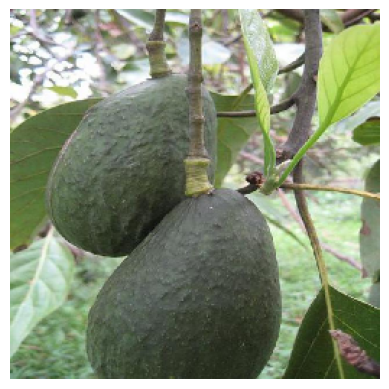

Câu hỏi: Trong ảnh có nhiêu trái cây?
Câu trả lời: ảnh có 2 trái cây


In [4]:
import matplotlib.pyplot as plt

# Load các mô hình
classifier_model = tf.keras.models.load_model("fruit_classifier_cnn.keras")
regression_model = tf.keras.models.load_model("fruit_regression_cnn.keras")
model = tf.keras.models.load_model("seq2seq_with_attention.keras")

# Load ảnh và chuyển thành tensor
data_train_path = "data/train"
fruit_classes = sorted(os.listdir(data_train_path))
image_sample_path = r"data\test\avocado\images\n11706761_6715_png_jpg.rf.e996a8abad5b410b4f8b859dcbb0b7a7.jpg"

img = tf.keras.preprocessing.image.load_img(image_sample_path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Dự đoán loại trái cây
fruit_type = classifier_model.predict(img_array)[0]
predicted_index = np.argmax(fruit_type)
predicted_fruit = fruit_classes[predicted_index]

# Dự đoán số lượng trái cây
fruit_count = regression_model.predict(img_array).squeeze()
fruit_count = float(fruit_count)

# Chuẩn bị đặc trưng ảnh
fruit_classifier_input = fruit_type.reshape(1, -1)
fruit_regression_input = np.array([[fruit_count]])

# Token hóa câu hỏi cụ thể
question = "Trong ảnh có nhiêu trái cây?"  # Câu hỏi muốn hỏi
"""
Gợi ý cho câu hỏi:
Trong ảnh số lượng trái cây là bao nhiêu?
Trong ảnh có bao nhiêu trái cây?

Ảnh chứa những loại trái cây nào?
Trái cây trong ảnh là gì?
Loại trái cây nào trong ảnh?

Ảnh có bao nhiêu trái cây loại gì?
Trong ảnh có bao nhiêu trái cây và là loại nào?
"""
question_seq = tokenizer.texts_to_sequences([question])
question_padded = pad_sequences(question_seq, maxlen=max_length, padding="post")

# Khởi tạo đầu vào cho decoder
start_token = tokenizer.word_index["<start>"]
decoder_input = np.zeros((1, decoder_seq_length))  # Shape: (1, 10)
decoder_input[0, 0] = start_token

# Sinh câu trả lời từ mô hình Seq2Seq với attention
output_sentence = []
for t in range(decoder_seq_length):  # Duyệt qua decoder_seq_length (10)
    predictions = model.predict(
        [question_padded, fruit_classifier_input, fruit_regression_input, decoder_input]
    )
    
    # Lấy token dự đoán tại timestep t
    predicted_id = np.argmax(predictions[0, t, :])

    # Kiểm tra token kết thúc
    if predicted_id == tokenizer.word_index["<end>"]:
        break

    output_sentence.append(predicted_id)
    if t < decoder_seq_length - 1:
        decoder_input[0, t + 1] = predicted_id

# Chuyển từ index thành từ ngữ
reverse_word_index = {v: k for k, v in tokenizer.word_index.items()}
predicted_text = " ".join([reverse_word_index[idx] for idx in output_sentence if idx in reverse_word_index])

plt.imshow(img)
plt.axis("off")
plt.show()

print("Câu hỏi:", question)
print("Câu trả lời:", predicted_text)